##Importing necessary libraries and data

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('all')
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install nlpaug

In [ ]:
!pip install tensorflow 

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [ ]:
from wordcloud import WordCloud
from tqdm.notebook import tqdm, trange
import re
import string
import matplotlib

In [ ]:
med_data = pd.read_csv('Train.csv')
med_data.head()

,Id,description,medical_specialty,sample_name,transcription
0,1,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
1,2,The patient is an 84-year-old female presente...,Cardiovascular / Pulmonary,Pericardial Effusion,"REASON FOR CONSULTATION:, Pericardial effusio..."
2,3,Hand dermatitis.,Dermatology,Dermatitis - SOAP,"SUBJECTIVE:, This is a 29-year-old Vietnamese..."
3,4,Recurrent degenerative spondylolisthesis and ...,Surgery,Lumbar Re-exploration,"PREOPERATIVE DIAGNOSIS: , Recurrent degenerati..."
4,5,Chiropractic IME with old files review. Deta...,IME-QME-Work Comp etc.,Chiropractic IME - 2,"DATE OF INJURY : October 4, 2000,DATE OF EXAMI..."


In [ ]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [ ]:
med_data.isnull().mean()*100

Id                   0.00000
description          0.00000
medical_specialty    0.00000
sample_name          0.00000
transcription        0.70922
dtype: float64

##Data Preprocessing

In [ ]:
med_data = med_data.loc[:, med_data.isnull().mean() < .99]
med_data = med_data.drop(med_data.index[12])

In [ ]:
med_data = med_data[med_data['transcription'].notna()]

In [ ]:
med_data.isnull().mean()*100

Id                   0.0
description          0.0
medical_specialty    0.0
sample_name          0.0
transcription        0.0
dtype: float64

In [ ]:
med_data['medical_specialty'].unique()

array([' Cardiovascular / Pulmonary', ' Dermatology', ' Surgery',
       ' IME-QME-Work Comp etc.', ' General Medicine', ' Orthopedic',
       ' Gastroenterology', ' Pain Management',
       ' Consult - History and Phy.', ' Radiology',
       ' Hematology - Oncology', ' Neurology', ' Nephrology', ' Podiatry',
       ' Office Notes', ' Rheumatology', ' Neurosurgery',
       ' Endocrinology', ' Discharge Summary', ' Bariatrics',
       ' SOAP / Chart / Progress Notes', ' ENT - Otolaryngology',
       ' Ophthalmology', ' Letters', ' Cosmetic / Plastic Surgery',
       ' Dentistry', ' Physical Medicine - Rehab',
       ' Psychiatry / Psychology', ' Autopsy', ' Sleep Medicine',
       ' Speech - Language', ' Allergy / Immunology',
       ' Lab Medicine - Pathology', ' Chiropractic', ' SCARF type'],
      dtype=object)

In [ ]:
specialisations_data = med_data.groupby("medical_specialty").agg("count")["transcription"].reset_index()
specialisations_data

,medical_specialty,transcription
0,Allergy / Immunology,5
1,Autopsy,2
2,Bariatrics,12
3,Cardiovascular / Pulmonary,308
4,Chiropractic,11
5,Consult - History and Phy.,309
6,Cosmetic / Plastic Surgery,19
7,Dentistry,21
8,Dermatology,23
9,Discharge Summary,75


In [ ]:
specs_tokeep = specialisations_data.loc[specialisations_data["transcription"]>20]
med_data = med_data[med_data["medical_specialty"].isin(specs_tokeep["medical_specialty"])]

In [ ]:
spec_count = med_data.groupby("medical_specialty").agg("count")["transcription"].reset_index()
spec_count

,medical_specialty,transcription
0,Cardiovascular / Pulmonary,308
1,Consult - History and Phy.,309
2,Dentistry,21
3,Dermatology,23
4,Discharge Summary,75
5,ENT - Otolaryngology,77
6,Gastroenterology,183
7,General Medicine,188
8,Hematology - Oncology,72
9,Nephrology,69


In [ ]:
med_data = med_data[['transcription', 'medical_specialty']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

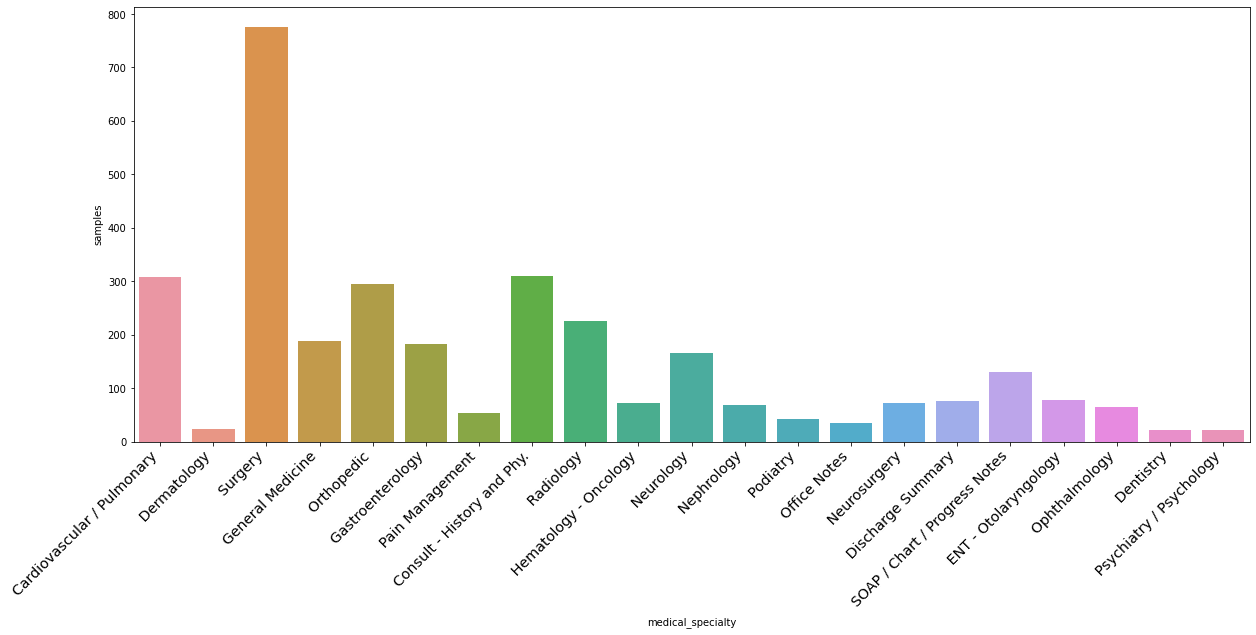

In [ ]:
plt.figure(figsize=(20,8))
x = med_data.medical_specialty.value_counts()
sns.countplot(med_data["medical_specialty"])
#plt.tight_layout()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.gca().set_ylabel('samples')

##Data Augmentation

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet', name='Synonym_Aug', aug_max=24)

In [ ]:
for i in trange(0, len(spec_count)-1):
    aug_multiplier = int(round(spec_count.transcription.max() / spec_count.transcription[i],0)) - 1
    data_filter = med_data.loc[med_data['medical_specialty'] == spec_count.medical_specialty[i]]
    for j in tqdm(data_filter.index):
        temps=aug.augment(data_filter.transcription[j],n=aug_multiplier)
        for sent in temps:
            medical_data1 = {'transcription': sent, 'medical_specialty': spec_count.medical_specialty[i]}
            med_data = med_data.append(medical_data1, ignore_index = True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

In [ ]:
med_data.groupby("medical_specialty").agg("count")["transcription"].reset_index()

,medical_specialty,transcription
0,Cardiovascular / Pulmonary,924
1,Consult - History and Phy.,927
2,Dentistry,777
3,Dermatology,782
4,Discharge Summary,750
5,ENT - Otolaryngology,770
6,Gastroenterology,732
7,General Medicine,752
8,Hematology - Oncology,792
9,Nephrology,759


##Text Preprocessing

In [ ]:
def text_preprocessing(data):
  data = str(data).lower()
  data = re.sub('\[.*?\]', '', data)
  data = re.sub('https?://\S+|www\.\S+', '', data)
  data = re.sub('<.*?>+', '', data)
  data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
  data = re.sub('\n', '', data)
  data = re.sub('\w*\d\w*', '', data)
  return data

In [ ]:
def remove_stopwords(text):
  return " ".join([word for word in text.split() if word not in STOPWORDS])

In [ ]:
med_data["transcription"] = med_data["transcription"].map(lambda text: text_preprocessing(text))

In [ ]:
med_data["transcription"] = med_data["transcription"].map(lambda text: remove_stopwords(text))

In [ ]:
med_data["word_cnt"] = med_data["transcription"].map(lambda text: len(str(text).split()))

In [ ]:
Y = pd.get_dummies(med_data["medical_specialty"]).values
print("Shape of label Tensor: ", Y.shape)

Shape of label Tensor:  (16560, 21)


Text(0, 0.5, 'Frequency')

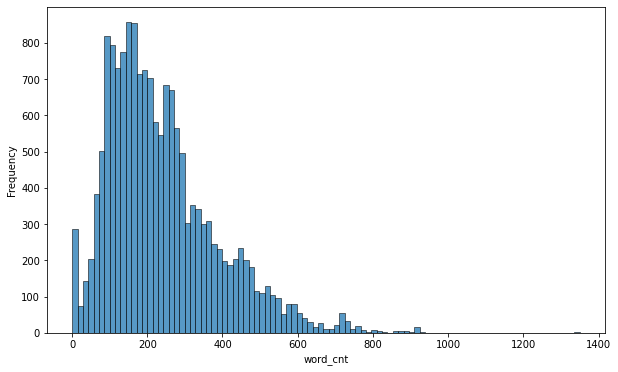

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(med_data["word_cnt"])
plt.ylabel("Frequency")

In [ ]:
documents = []
for transcript in med_data["transcription"]:
  documents.append(transcript.split(' '))

In [ ]:
len(documents)

16560

##Building word2vec model

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Training the Word2Vec model
model = Word2Vec(documents, #Word list
                   min_count=5, #Ignore all words with total frequency lower than this                           
                   workers=4, #Number of CPUs
                   size=100,  #Embedding size
                   window=5 #Maximum Distance between current and predicted word
                  # iter=10   #Number of iterations over the text corpus
                  )

In [ ]:
#How many words in the model and how many features
model.wv.vectors.shape

(19390, 100)

In [ ]:
all_words = model.wv.index2word              #key_to_index
top_words = model.wv.index2word[0:5]   
top_words

['patient', 'right', 'left', 'history', 'procedure']

In [ ]:
print('Vocabulary size: %d' % len(all_words))

Vocabulary size: 19390


In [ ]:
# Finding Word Vectors
vector = model.wv['mmode']
vector

array([-0.00392896,  0.00715722, -0.02176765,  0.01912895,  0.02265569,
       -0.01214194, -0.06965761, -0.02773373, -0.02101657,  0.01147723,
        0.02568236,  0.00415016, -0.18019873, -0.00984868, -0.02648419,
        0.06485286,  0.03717923, -0.07819723,  0.14979944, -0.02241551,
       -0.02614771,  0.06110897, -0.08734152,  0.01829945, -0.08279822,
       -0.01305735,  0.00911939,  0.10257045,  0.06517868,  0.02385052,
        0.03884796, -0.07463433,  0.08943561, -0.02463497, -0.05007187,
       -0.04740383, -0.01680585, -0.05593285, -0.1658482 ,  0.00018622,
        0.03029863,  0.04255794,  0.04348214, -0.00064061, -0.02406331,
       -0.04091139, -0.07769915, -0.01759164,  0.06299429, -0.08240928,
        0.00386008, -0.0108714 ,  0.01660807, -0.05934289, -0.01411952,
       -0.02994857, -0.01403407,  0.05764773, -0.0663185 ,  0.05321218,
        0.05072212, -0.02672485, -0.04369503,  0.10039517,  0.02880941,
        0.04111687, -0.0142905 , -0.01343953,  0.03437955, -0.06

In [ ]:
#Finding similar words
similar = model.wv.most_similar('anesthetic')
similar

[('anaesthetic', 0.8797316551208496),
 ('anaesthesia', 0.8252983093261719),
 ('anesthesia', 0.7991713881492615),
 ('footanesthesia', 0.6193558573722839),
 ('percolation', 0.6188280582427979),
 ('sedationcomplications', 0.6107694506645203),
 ('shoplift', 0.5796117782592773),
 ('anesthesiaprocedure', 0.5546985864639282),
 ('endotrachealindications', 0.5543976426124573),
 ('endotrachealestimated', 0.552969217300415)]

##Saving the model

In [ ]:
model.save("word2vec_Medical Specialty Classification")

##Train test validation split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = med_data["transcription"]
y = Y

In [ ]:
#train test validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify = y_train)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(9936,)
(3312,)
(9936, 21)
(3312, 21)
(3312,)
(3312, 21)


In [ ]:
# building tokenizer to form a token for each word in each transcription

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [ ]:
#Convert words to integers

top_words = 10000 #reducing no of words to increase the processing speed

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# pad sequences to mmake each transcription of the same size
#taking 300  based on avg length of the transcription form histogram
padding_max_len = 300

X_train = pad_sequences(X_train, maxlen=padding_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=padding_max_len, padding='post')

##Building Embedding Matrix

In [ ]:
# Building embedding matrix from above Word2Vec model(pre trained model) 

word2vec_model = Word2Vec.load("word2vec_Medical Specialty Classification")  #loading the one created above

In [ ]:
word2vec_model.wv.vectors.shape

(19390, 100)

In [ ]:
#embedding length
embedding_vector_length = word2vec_model.wv.vectors.shape[1]  
embedding_vector_length

100

In [ ]:
#Initialising an embedding matrix with zeros

embedding_matrix = np.zeros((top_words+1, embedding_vector_length))

tokenizer.word_index.items()

for word,key in sorted(tokenizer.word_index.items(), key = lambda x:x[1]):
  if key > top_words:
    break
  if word in word2vec_model.wv.index2word:
    #print(word)
    embedding_vector = word2vec_model.wv[word]
    #print(embedding_vector)
    embedding_matrix[key] = embedding_vector
    #print(embedding_matrix[i])

In [ ]:
embedding_matrix[tokenizer.word_index['procedure']]

array([ 0.89806712,  2.41753221,  2.49034047, -1.04727495, -3.13648319,
        1.48738551,  0.40522552, -1.85123932,  0.58981621,  0.43841514,
       -2.35428333, -0.86637813, -0.75034386, -0.75386864, -0.08538377,
        0.40566564, -0.44479945, -2.21926332, -1.38568056, -0.00526984,
        0.40634137,  3.15927696, -0.98434454,  1.67123377, -1.01478386,
       -1.01730824,  2.38655186, -0.05847777,  1.16528022, -3.07321501,
        1.13080847, -0.69576931, -0.94133925, -2.03524923, -2.91127968,
       -1.49570715, -1.75666952, -1.28871155,  2.29650116,  1.77698088,
        1.3276366 , -0.44421998,  1.69221199,  2.4132061 , -1.11087608,
        1.13504732, -4.33295536, -1.50407553, -1.6110276 , -0.83589101,
       -0.95675147, -0.48486012, -2.07361221,  0.02906841, -0.76202488,
       -0.55820245,  1.15013945, -0.39617157, -0.18372576,  3.62188053,
       -1.61419129,  4.08228207,  0.86898547, -0.52519077,  2.24899244,
       -1.97181249,  0.89996076,  1.2056644 ,  1.5688839 , -0.40

##Creating an Embedding Layer

In [ ]:
# Create an embedding layer
#Output from Embedding is 3 dimension
#batch_size x max_review_length x embedding_vector_length

embedding_layer = Embedding(top_words+1, embedding_vector_length, weights=[embedding_matrix],
                             input_length=padding_max_len,trainable=False)


##Model 0

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
import xgboost as xgb 

In [ ]:
x_train_embed = (embedding_layer(X_train).numpy())
x_test_embed = (embedding_layer(X_test).numpy())

In [ ]:
rf = RandomForestClassifier(random_state=12)

In [ ]:
grid_params = {'n_estimators':[100, 150, 200], 'max_depth':[20, 30, 40, 50], 'min_samples_split':[1, 5, 9], 'ccp_alpha':[0, 4, 10, 20]}

In [ ]:
random_search = RandomizedSearchCV(rf, grid_params, scoring="accuracy", random_state=2, return_train_score=True, n_jobs=-1)

In [ ]:
# grid_search = GridSearchCV(rf, param_grid=grid_params, n_jobs=-1, return_train_score=True, scoring='accuracy', verbose=4)

In [ ]:
clf = random_search.fit(X_train, y_train)

In [ ]:
random_search.best_estimator_

RandomForestClassifier(ccp_alpha=0, max_depth=20, min_samples_split=5,
                       n_estimators=200, random_state=12)

In [ ]:
y_pred = clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.4277375201288245

##Imports for building LSTM models

In [ ]:
# Using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Embedding,LSTM ,Bidirectional
from tensorflow.keras import regularizers

##Model 1

In [ ]:
model1 = Sequential()

model1.add(embedding_layer)

#LSTM
model1.add(LSTM(32))

#dense layer
model1.add(Dense(units=21,activation='softmax')) 

model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000100   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 21)                693       
                                                                 
Total params: 1,017,817
Trainable params: 17,717
Non-trainable params: 1,000,100
_________________________________________________________________
None


In [ ]:
model_history = model1.fit(X_train, y_train, batch_size=200, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
50/50 [==============================] - 18s 310ms/step - loss: 2.9852 - accuracy: 0.0884 - val_loss: 2.9197 - val_accuracy: 0.1211
Epoch 2/30
50/50 [==============================] - 15s 297ms/step - loss: 2.8534 - accuracy: 0.1476 - val_loss: 2.7946 - val_accuracy: 0.1715
Epoch 3/30
50/50 [==============================] - 17s 338ms/step - loss: 2.7024 - accuracy: 0.1972 - val_loss: 2.6662 - val_accuracy: 0.2083
Epoch 4/30
50/50 [==============================] - 15s 301ms/step - loss: 2.6081 - accuracy: 0.2205 - val_loss: 2.6209 - val_accuracy: 0.1990
Epoch 5/30
50/50 [==============================] - 15s 305ms/step - loss: 2.6739 - accuracy: 0.1868 - val_loss: 2.7003 - val_accuracy: 0.1790
Epoch 6/30
50/50 [==============================] - 15s 306ms/step - loss: 2.6268 - accuracy: 0.2035 - val_loss: 2.6190 - val_accuracy: 0.2002
Epoch 7/30
50/50 [==============================] - 15s 307ms/step - loss: 2.5746 - accuracy: 0.2188 - val_loss: 2.5926 - val_accuracy: 0.2150

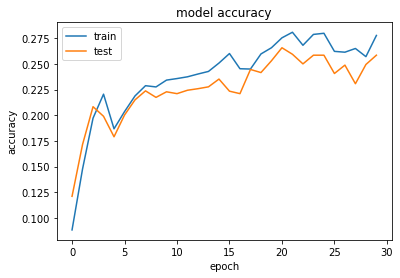

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

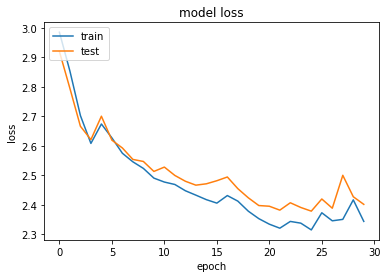

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 2

####In order to improve upon the previous model we make use of a bidirectional LSTM model to capture more context. We also increase the number of neurons.

In [ ]:
model2 = Sequential()

model2.add(embedding_layer)

model2.add(Bidirectional(LSTM(64)))

model2.add(Dense(units=21,activation='softmax')) 

model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000100   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 21)                2709      
                                                                 
Total params: 1,087,289
Trainable params: 87,189
Non-trainable params: 1,000,100
_________________________________________________________________
None


In [ ]:
model_history = model2.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
100/100 [==============================] - 66s 614ms/step - loss: 2.3237 - accuracy: 0.3478 - val_loss: 1.6905 - val_accuracy: 0.5266
Epoch 2/10
100/100 [==============================] - 63s 631ms/step - loss: 1.3901 - accuracy: 0.6015 - val_loss: 1.2314 - val_accuracy: 0.6437
Epoch 3/10
100/100 [==============================] - 61s 606ms/step - loss: 1.0317 - accuracy: 0.6847 - val_loss: 1.0295 - val_accuracy: 0.6830
Epoch 4/10
100/100 [==============================] - 60s 600ms/step - loss: 0.8603 - accuracy: 0.7240 - val_loss: 0.9339 - val_accuracy: 0.7017
Epoch 5/10
100/100 [==============================] - 61s 606ms/step - loss: 0.7562 - accuracy: 0.7452 - val_loss: 0.9011 - val_accuracy: 0.7023
Epoch 6/10
100/100 [==============================] - 63s 634ms/step - loss: 0.6853 - accuracy: 0.7651 - val_loss: 0.8747 - val_accuracy: 0.6984
Epoch 7/10
100/100 [==============================] - 62s 623ms/step - loss: 0.6343 - accuracy: 0.7741 - val_loss: 0.8458 - val_ac

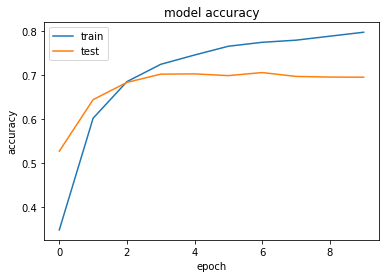

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

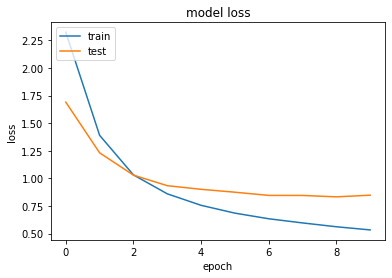

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 3

####Clearly model 2 was a significant improvement from model 1, however analysing the plots of loss/epoch we can see that the model begins to overfit. We train another Bi-LSTM model with lesser number of neurons to address this problem

In [ ]:
#improving above overfitted model:

model2_1 = Sequential()

model2_1.add(embedding_layer)

model2_1.add(Bidirectional(LSTM(32)))

model2_1.add(Dense(units=21,activation='softmax')) 

model2_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model2_1.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000100   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 21)                1365      
                                                                 
Total params: 1,035,513
Trainable params: 35,413
Non-trainable params: 1,000,100
_________________________________________________________________
None


In [ ]:
model_history = model2_1.fit(X_train, y_train, batch_size=100, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
100/100 [==============================] - 41s 368ms/step - loss: 2.6739 - accuracy: 0.2554 - val_loss: 2.2540 - val_accuracy: 0.3995
Epoch 2/8
100/100 [==============================] - 36s 365ms/step - loss: 1.9257 - accuracy: 0.4779 - val_loss: 1.6949 - val_accuracy: 0.5353
Epoch 3/8
100/100 [==============================] - 38s 381ms/step - loss: 1.4835 - accuracy: 0.5924 - val_loss: 1.3833 - val_accuracy: 0.6147
Epoch 4/8
100/100 [==============================] - 36s 359ms/step - loss: 1.2180 - accuracy: 0.6527 - val_loss: 1.2202 - val_accuracy: 0.6353
Epoch 5/8
100/100 [==============================] - 37s 370ms/step - loss: 1.0452 - accuracy: 0.6906 - val_loss: 1.1261 - val_accuracy: 0.6558
Epoch 6/8
100/100 [==============================] - 36s 361ms/step - loss: 0.9527 - accuracy: 0.7068 - val_loss: 1.0719 - val_accuracy: 0.6751
Epoch 7/8
100/100 [==============================] - 36s 364ms/step - loss: 0.8847 - accuracy: 0.7233 - val_loss: 1.0323 - val_accuracy:

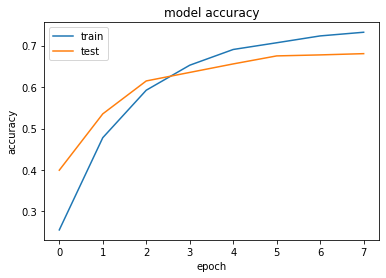

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

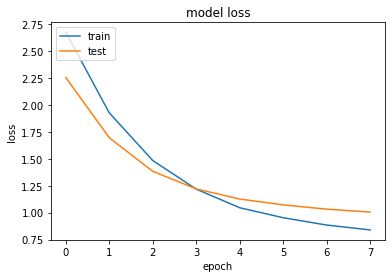

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()